In [20]:
import models
import utils
import torch
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
from permutation_metrics import rank_similarities, rank_similarities_real

%load_ext autoreload
%autoreload 2

torch.manual_seed(42)
np.random.seed(42)

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

guess_prob = 1/5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset: Sigmoid Uncorrel

In [57]:
R = torch.tensor(np.load('../datasets/sigmoid_irf_uncorrel.npy'), dtype=dtype)
A_true = np.load('../datasets/students_uncorrel.npy')
D_true = np.load('../datasets/questions_uncorrel.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [58]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-4,-1), 'reg':(-4,1)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.06627897035983005, reg=5.883596555133605, momentum=0


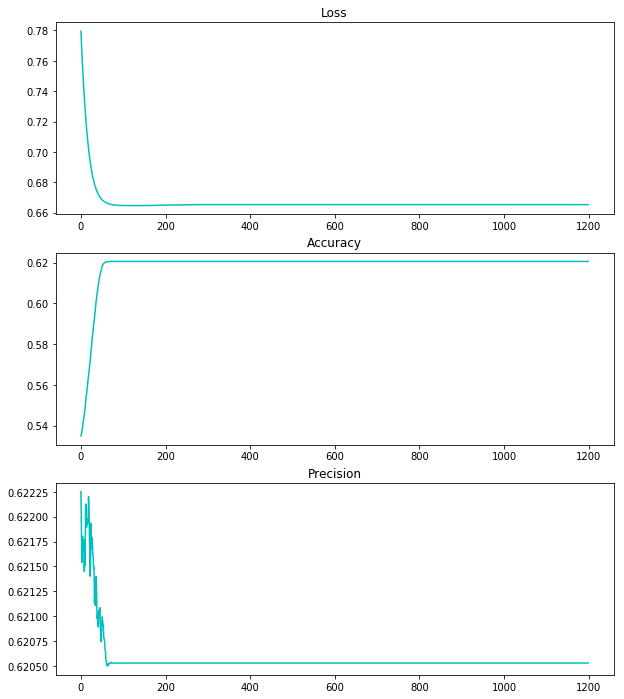

In [59]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=0.006, weight_decay=r, momentum=0)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 1200, R)
utils.plot_train_metrics(losses, train_acc, precision)

Here we calculate the RMSE between the inferred A and D matrices and their actual counterparts.

In [60]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.17581726610660553
RMSE(D, D_true) =  0.07938581705093384


We now compare the student ranking produced by the inferred abilities matrix to the actual ranking, and to the baseline ranking produced by the students' raw scores.

In [61]:
results = rank_similarities(A_true, R.detach().numpy(), sigmoid_irf.A.detach().numpy())
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.434 (p-value 0.0)
            Spearman: 0.608 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.428 (p-value 0.0)
            Spearman: 0.607 (p-value 0.0)  
            
    Average difference: -0.004 (absolute diff., vs. the baseline) 
    


For the sake of some exploration we compare the inferred model's accuracy with the accuracy of the model using the actual A and D matrices used to simulate the dataset in the first place (this is called oracle accuracy). We also look at the scores distribution generated by the actual A and D matrices. As it turns out this distribution says a lot about the general behavior of the model, and explains why the (actual) floored exponential model attains higher accuracy on its own dataset than the does the (actual) sigmoid model on its dataset.

In [10]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.two_param_sigmoid_irf(_A[:, concepts[1]], _D[concepts], guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.61892
Inferred model accuracy:  0.6205300092697144
Inferred model precision:  0.6205300092697144


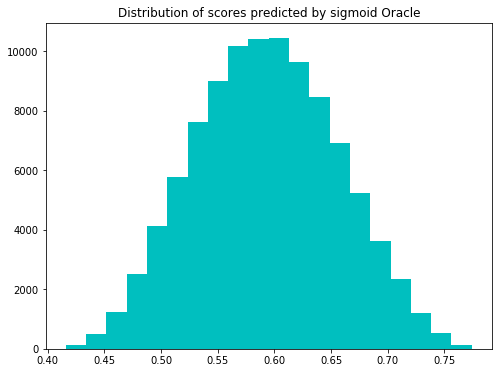

In [11]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by sigmoid Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: Sigmoid Correl

In [12]:
R = torch.tensor(np.load('../datasets/sigmoid_irf_correl.npy'), dtype=dtype)
A_true = np.load('../datasets/students_correl.npy')
D_true = np.load('../datasets/questions_correl.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [13]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-4,-1), 'reg':(-3,2)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.08105016126411578, reg=7.510418138777542, momentum=0


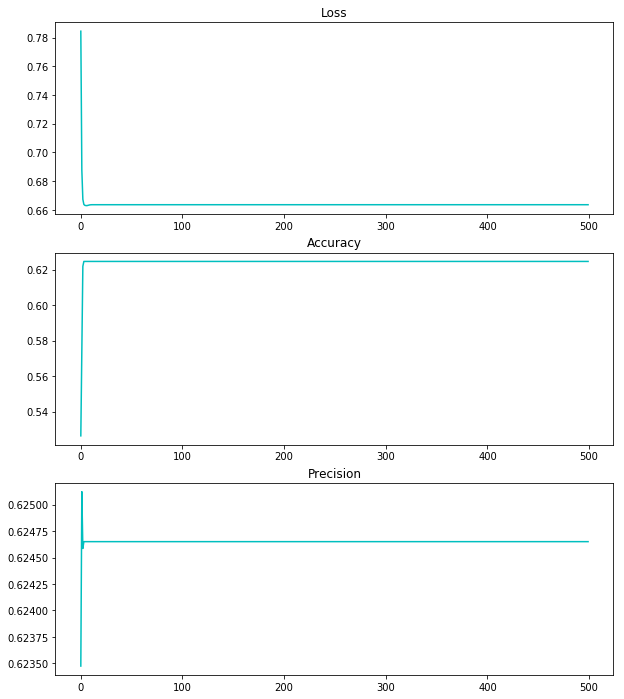

In [18]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=0)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 500, R)
utils.plot_train_metrics(losses, train_acc, precision)

In [19]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.2396552413702011
RMSE(D, D_true) =  0.5710631608963013


In [20]:
from collections import Counter
counts = Counter(concepts[1])
total = len(concepts[1])
weights = {k: v/total for k, v in counts.items()}
weights

{4: 0.15, 2: 0.17, 0: 0.2, 1: 0.28, 3: 0.2}

In [26]:
weights = np.array([0.2, 0.28, 0.17, 0.2, 0.15])
results = rank_similarities(A_true, R.detach().numpy(), sigmoid_irf.A.detach().numpy(), skill_weights=weights)
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.274 (p-value 0.0)
            Spearman: 0.397 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.277 (p-value 0.0)
            Spearman: 0.408 (p-value 0.0)  
            
    Average difference: 0.007 (absolute diff., vs. the baseline) 
    


In [27]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.two_param_sigmoid_irf(_A[:, concepts[1]], _D[concepts], guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.62162
Inferred model accuracy:  0.6246500015258789
Inferred model precision:  0.6246500015258789


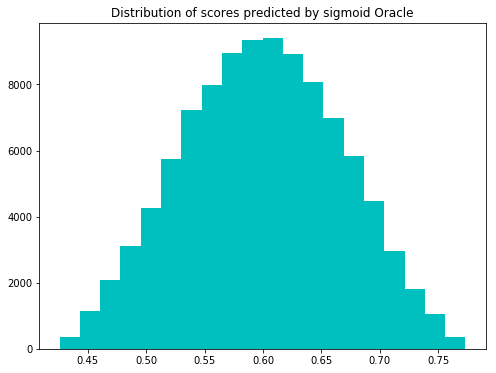

In [28]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by sigmoid Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: FE Uncorrel

In [29]:
R = torch.tensor(np.load('../datasets/floored_exp_uncorrel.npy'), dtype=dtype)
A_true = np.load('../datasets/students_uncorrel.npy')
D_true = np.load('../datasets/questions_uncorrel.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [30]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-3,2), 'reg':(-4,0)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=10.431827200054897, reg=0.0005575453980775369, momentum=0


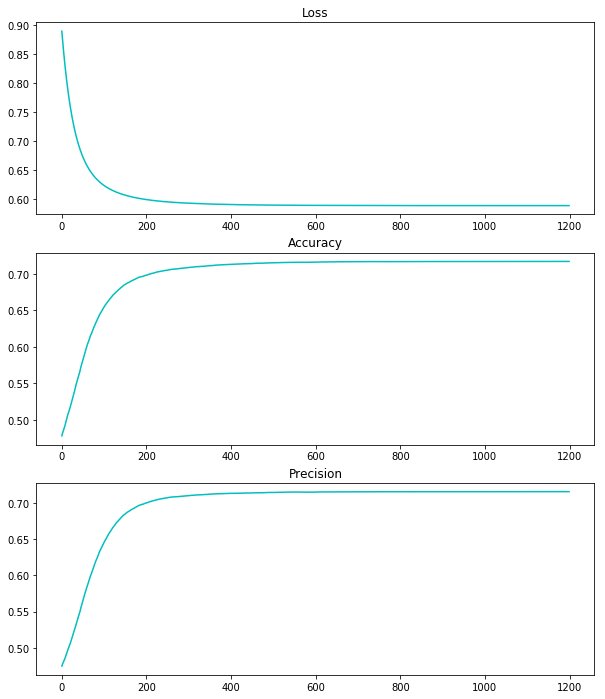

In [31]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=0)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 1200, R)
utils.plot_train_metrics(losses, train_acc, precision)

In [32]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.08851233869791031
RMSE(D, D_true) =  0.13645297288894653


In [33]:
results = rank_similarities(A_true, R.detach().numpy(), sigmoid_irf.A.detach().numpy())
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.847 (p-value 0.0)
            Spearman: 0.966 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.864 (p-value 0.0)
            Spearman: 0.975 (p-value 0.0)  
            
    Average difference: 0.013 (absolute diff., vs. the baseline) 
    


In [34]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.floored_exp_irf(_A[:, concepts[1]], _D[concepts], 10, guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.79024
Inferred model accuracy:  0.7171599864959717
Inferred model precision:  0.7153701782226562


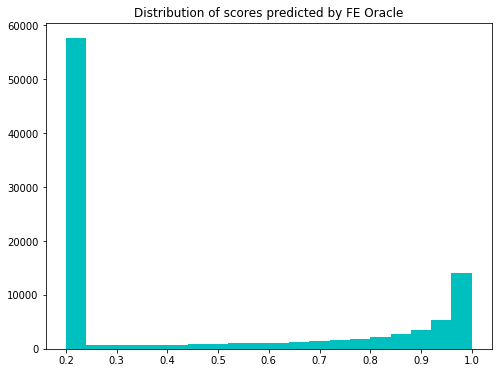

In [35]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by FE Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: FE Correl

In [36]:
R = torch.tensor(np.load('../datasets/floored_exp_correl.npy'), dtype=dtype)
A_true = np.load('../datasets/students_correl.npy')
D_true = np.load('../datasets/questions_correl.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [37]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-3,2), 'reg':(-4,0)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=34.77998816092339, reg=0.0009083381663660582, momentum=0


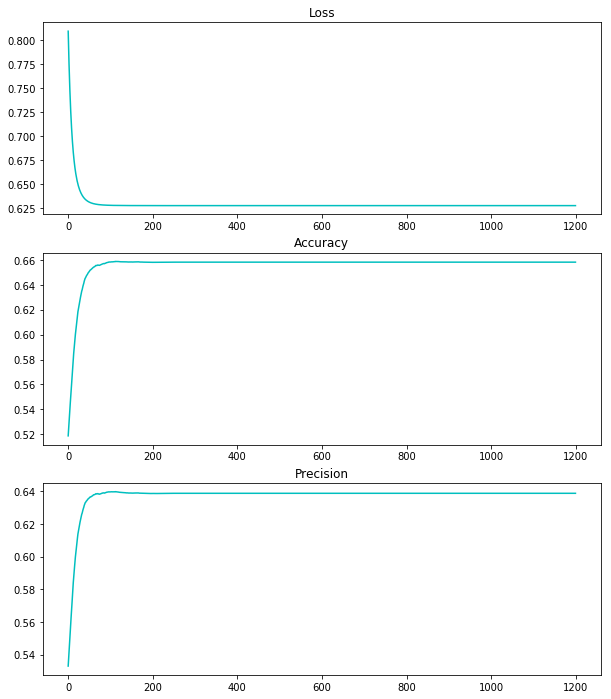

In [38]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=0)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 1200, R)
utils.plot_train_metrics(losses, train_acc, precision)

In [39]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.1286575049161911
RMSE(D, D_true) =  0.437646746635437


In [41]:
weights = np.array([0.2, 0.28, 0.17, 0.2, 0.15])
results = rank_similarities(A_true, R.detach().numpy(), sigmoid_irf.A.detach().numpy(), skill_weights=weights)
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.736 (p-value 0.0)
            Spearman: 0.902 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.706 (p-value 0.0)
            Spearman: 0.884 (p-value 0.0)  
            
    Average difference: -0.024 (absolute diff., vs. the baseline) 
    


In [42]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.floored_exp_irf(_A[:, concepts[1]], _D[concepts], 10, guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.80246
Inferred model accuracy:  0.6582499742507935
Inferred model precision:  0.6388927102088928


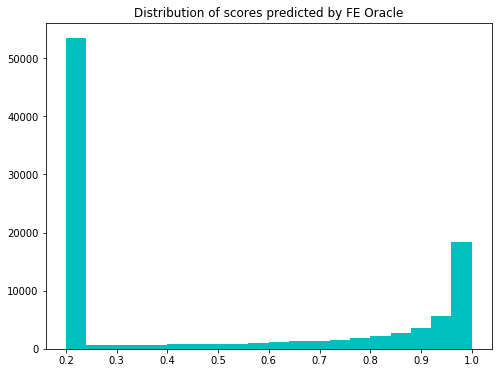

In [43]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by FE Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: Real

In [26]:
R = torch.tensor(np.genfromtxt('../datasets/real_data.csv', delimiter=','), dtype=dtype)
num_students = R.shape[0]
# We assume the real data set tests a single concept

train = R[:int(num_students*0.8)]
num_students, num_questions = train.shape
num_concepts = 1
concepts = (list(range(num_questions)), [0]*num_questions)

test = R[int(num_students*0.8):]

We first infer the difficulty matrix from the train set.

In [27]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-4,1), 'reg':(-4,1), 'momentum':(-1,0)}, 10, 300, train)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.34702669886504106, reg=0.00012674255898937226, momentum=0.9330606024425664


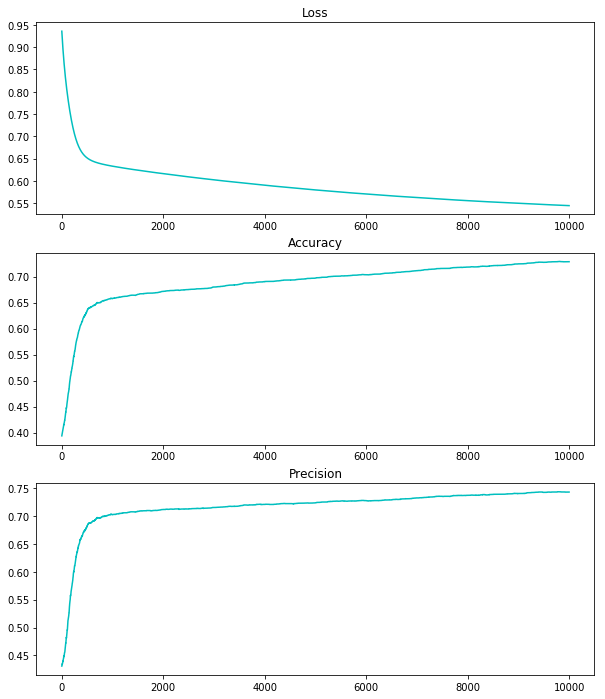

In [28]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=0)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 10000, train)
utils.plot_train_metrics(losses, train_acc, precision)

In [31]:
print(rank_similarities_real(train.numpy(), sigmoid_irf.A.detach().numpy())['summary'])


    Summary of Ranking Evaluation:
    Correlations between R and A_pred.
    
        Baseline: 
            Kendall:0.613 (p-value 0.0)
            Spearman: 0.773 (p-value 0.0) 
            
        Average Correlation: 0.693
    


In [32]:
D = sigmoid_irf.D

We now learn the abilities matrix of students in the test set from the first 8 questions of the test set.

In [33]:
test1 = test[:, :-1]
test2 = test[:, -1]
num_students, num_questions = test1.shape
num_concepts = 1
concepts = (list(range(num_questions)), [0]*num_questions)

In [34]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-4,1), 'reg':(-4,0), 'momentum':(-1,0)}, 10, 300, test1)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=3.4779988160923385, reg=0.0009083381663660582, momentum=0.1396030388721687


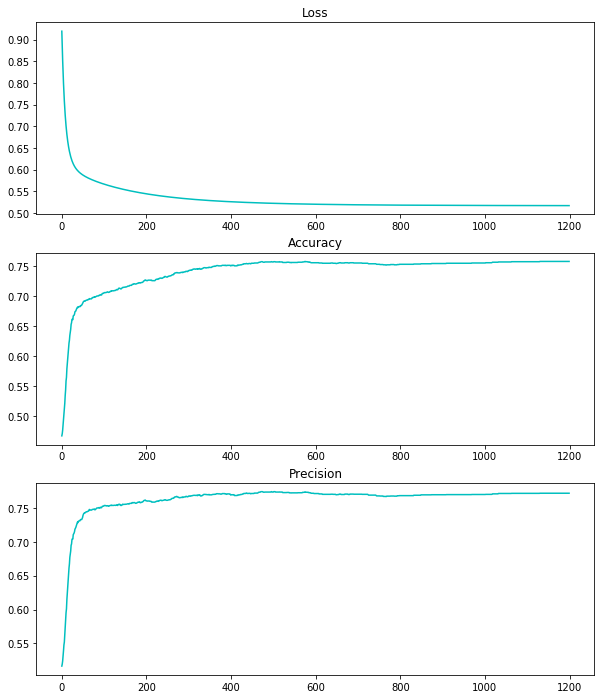

In [35]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 1200, test1)
utils.plot_train_metrics(losses, train_acc, precision)

In [36]:
A = sigmoid_irf.A

probs = models.two_param_sigmoid_irf(A, D[-1], guess_prob)

preds = (probs.detach().numpy() >= 0.5).astype(int)

print('Test acc = {}'.format(np.mean((preds == test2.numpy()).astype(int))))

Test acc = 0.7345920138888888
